In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Balanced

In [2]:
separated_means = [[-3, 2], [-1.5, 2], [0, 2], [1.5, 2], [3, 2], [-3, 0], [-1.5, 0], [0, 0], [1.5, 0], [3, 0]]
overlapped_means = [[-2, 1], [-1.5, 1], [0, 1], [1.5, 1], [2, 1], [-2, 0], [-1.5, 0], [0, 0], [1.5, 0], [2, 0]]
highly_overlapped_means = [[-2, 1], [-1.5, 1], [-1, 1], [-0.5, 1], [0, 1], [-2, 0], [-1.5, 0], [-1, 0], [-0.5, 0], [0, 0]]

In [3]:
size_per_category = 1000

In [4]:
palette = ['red', 'green', 'blue', 'cyan', 'magenta', 'orange', 'yellow', 'lightgreen', 'skyblue', 'orchid']

In [5]:
def generate_distribution(mean_array, size_per_category):
    points = pd.DataFrame()
    x = []
    y = []
    category = []
    index = 0
    for mean in mean_array:
        gaussian_normal_points = np.random.normal(loc=mean, scale=[0.3,0.3], size=[size_per_category, 2])
        x += list(gaussian_normal_points[:, 0])
        y += list(gaussian_normal_points[:, 1])
        category += [index] * size_per_category
        index += 1
    points['x'] = x
    points['y'] = y
    points['category'] = category
    return points

In [6]:
def plot_distribution(distribution):
    legend = [('Category '+ str(index+1)) for index in range(10)]
    plt.figure(figsize=(15,8))
    for index in range(10):
        data = distribution[distribution['category'] == index]
        plt.scatter(data['x'], data['y'], c=palette[index], s=5)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend((legend), loc=1)

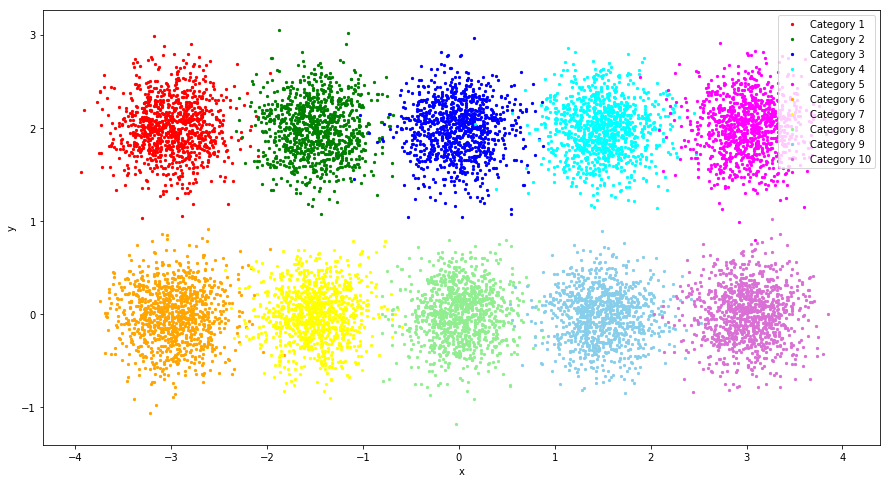

In [7]:
separated = generate_distribution(separated_means, size_per_category)
plot_distribution(separated)

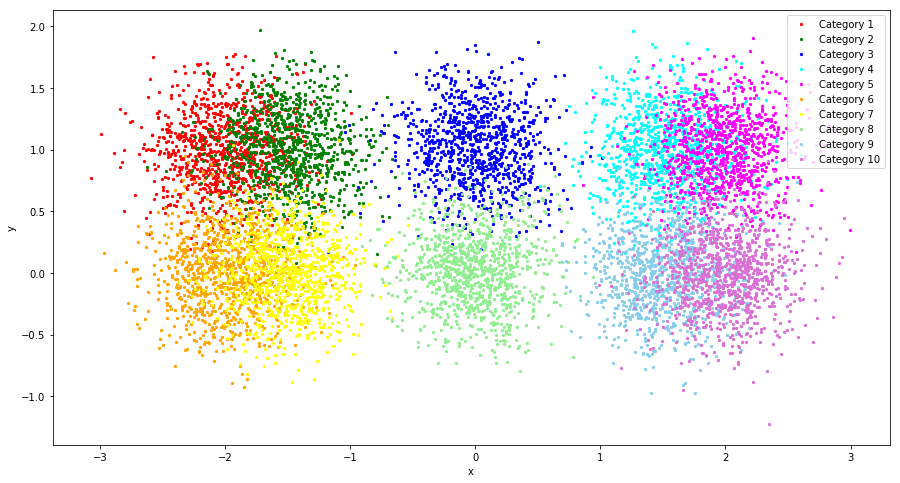

In [8]:
overlapped = generate_distribution(overlapped_means, size_per_category)
plot_distribution(overlapped)

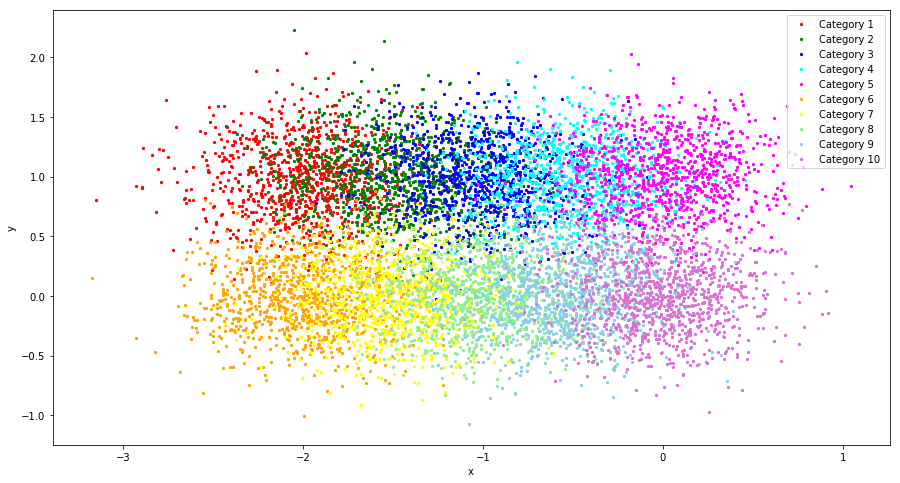

In [9]:
highly_overlapped = generate_distribution(highly_overlapped_means, size_per_category)
plot_distribution(highly_overlapped)

# Imbalanced

Run for r in [0.01, 0.05, 0.1, 0.5, 0.9] and m in [1,9]

Simulating for one test case:

In [10]:
m = 2
r = 0.01
k = 10
imbalanced_size = 2000

In [11]:
def sample_imbalanced_data(data, imbalanced_size, m, r, k):
    p_min = r/10 #for m classes
    p_max = (1 - (p_min * m))/(k - m) #for k-m classes
    minority_positions = ([p_min] * m + [p_max] * (k - m))
    np.random.shuffle(minority_positions)
    class_probabilities = [(proba/size_per_category) for proba in minority_positions]
    p = [class_probabilities[category] for category in data['category']]
    indices = np.arange(len(data))
    selected_indices = np.random.choice(indices, imbalanced_size, p=p)
    imbalanced_samples = data.iloc[selected_indices, :]
    imbalanced_samples.reset_index(inplace=True, drop=True)
    return imbalanced_samples

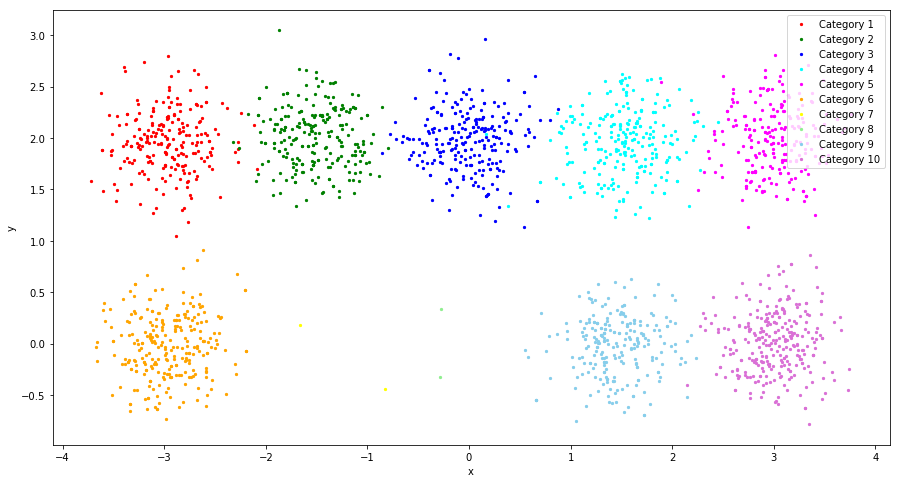

In [12]:
separated_imbalanced = sample_imbalanced_data(separated, imbalanced_size, m, r, k)
plot_distribution(separated_imbalanced)

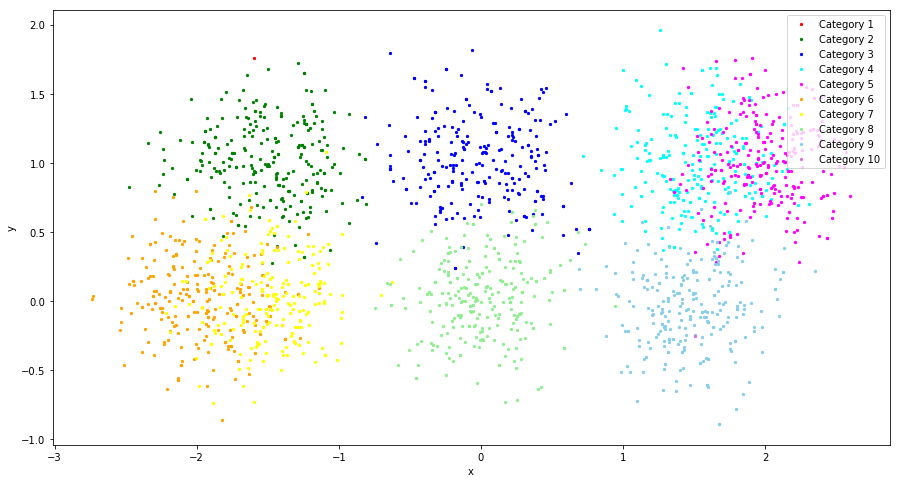

In [13]:
overlapped_imbalanced = sample_imbalanced_data(overlapped, imbalanced_size, m, r, k)
plot_distribution(overlapped_imbalanced)

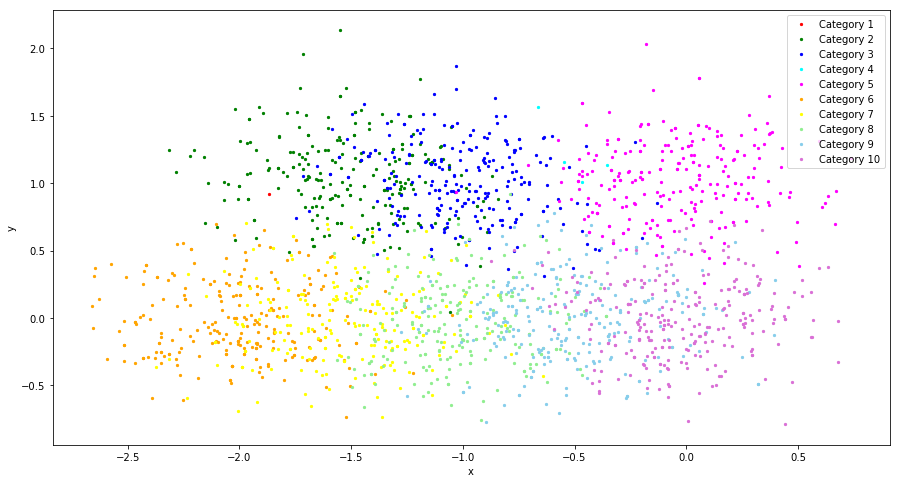

In [14]:
highly_overlapped_imbalanced = sample_imbalanced_data(highly_overlapped, imbalanced_size, m, r, k)
plot_distribution(highly_overlapped_imbalanced)

In [15]:
def imbalance_ratio(data):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    count_max = max(counts)
    count_min = min(counts)
    IR = count_max / count_min
    return IR

In [16]:
imbalance_ratio(separated_imbalanced)

146.5

In [17]:
def hellinger_distance(vec1, vec2):
    return np.sqrt(np.sum((np.sqrt(vec1) - np.sqrt(vec2)) ** 2)) / np.sqrt(2)

In [18]:
def imbalance_degree(data, c):
    value_counts = data['category'].value_counts()
    counts = [count for category, count in value_counts.iteritems()]
    size = len(data)
    p = np.array(counts) / size
    if (len(p) < c):
        p = np.concatenate((p, [0] * (c-len(p))))
    b = [1/c] * c
    m = 0
    for prob in (p-b):
        if prob < 0:
            m +=1
    p_m = [0] * m + [1/c] * (c-m-1) + [1-(c-m-1)/c]
    ID = (hellinger_distance(p,b) / hellinger_distance(p_m,b)) + (m-1)
    return ID

In [19]:
imbalance_degree(overlapped_imbalanced, k)

1.852308231348733

In [20]:
def log_likelihood_index(data):
    c = len(np.unique(data['category']))
    value_counts = data['category'].value_counts()
    size = len(data)
    proba = [(count/size) for category, count in value_counts.iteritems()]
    summation = np.sum([(p*np.log(p*c)) for p in proba])
    LLI = 2 * summation
    return LLI

In [21]:
log_likelihood_index(separated_imbalanced)

0.4283526464876558

# Simulating for all values

In [22]:
def compute_graphs(distribution, imbalanced_size, k):
    results = []
    for m in range(1,k):
        IR = []
        ID = []
        LLI = []
        for r in [0.01, 0.05, 0.1, 0.5, 0.9]:
            imbalanced_data = sample_imbalanced_data(distribution, imbalanced_size, m, r, k)
            IR.append(imbalance_ratio(imbalanced_data))
            ID.append(imbalance_degree(imbalanced_data, k))
            LLI.append(log_likelihood_index(imbalanced_data))
        result = {}
        result['ir'] = IR
        result['id'] = ID
        result['lli'] = LLI
        results.append(result)
    return results

In [34]:
def plot_graph(distribution, metric, legend, k=10, imbalanced_size=5000):
    data_points = compute_graphs(distribution, imbalanced_size, k)
    #plt.figure(figsize=(10,6))
    index = 0
    r_values = [0.01, 0.05, 0.1, 0.5, 0.9]
    legend = [('m = ' + str(i)) for i in range(1,10)]
    for category in data_points:
        scores = category[metric]
        plt.plot(r_values, scores)
        plt.xlabel('r')
        plt.ylabel(metric.upper())
        print(scores)
    plt.legend((legend), loc=1, fontsize='medium', framealpha=0.2)

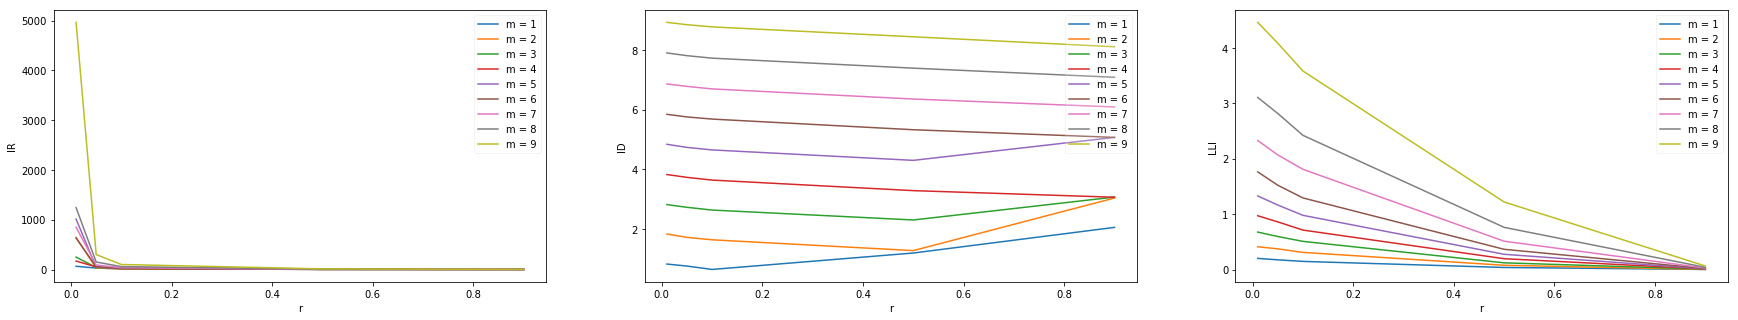

In [24]:
plt.figure(figsize=(30,5))
plt.subplot(131)
plot_graph(separated, 'ir', legend=True)
plt.subplot(132)
plot_graph(separated, 'id', legend=False)
plt.subplot(133)
plot_graph(separated, 'lli', legend=False)

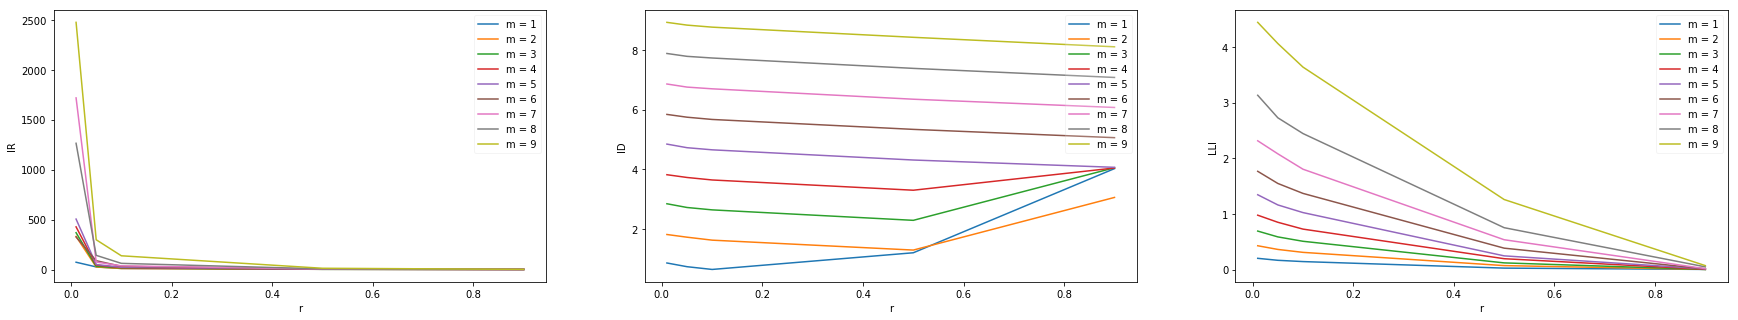

In [25]:
plt.figure(figsize=(30,5))
plt.subplot(131)
plot_graph(overlapped, 'ir', legend=True)
plt.subplot(132)
plot_graph(overlapped, 'id', legend=False)
plt.subplot(133)
plot_graph(overlapped, 'lli', legend=False)

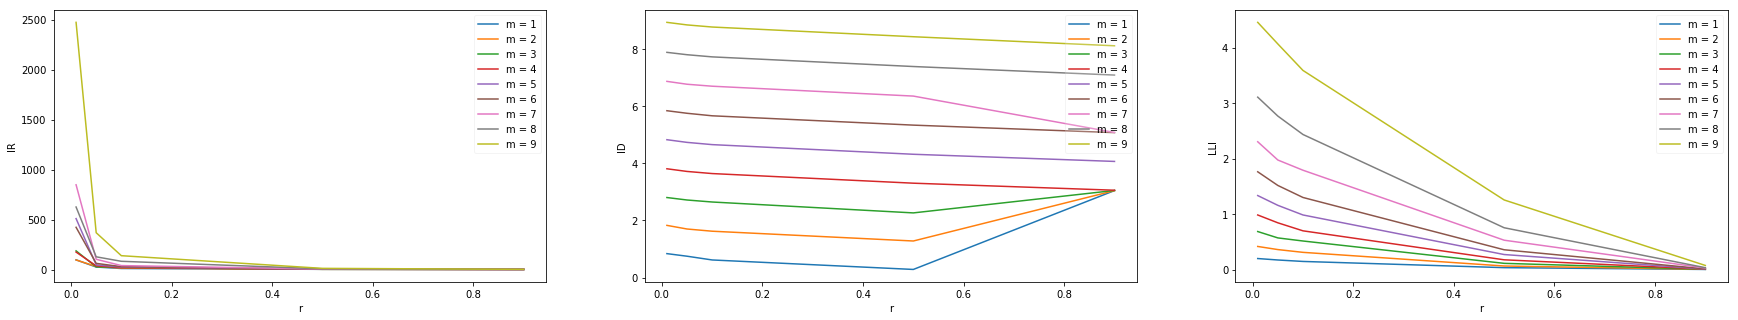

In [26]:
plt.figure(figsize=(30,5))
plt.subplot(131)
plot_graph(highly_overlapped, 'ir', legend=True)
plt.subplot(132)
plot_graph(highly_overlapped, 'id', legend=False)
plt.subplot(133)
plot_graph(highly_overlapped, 'lli', legend=False)

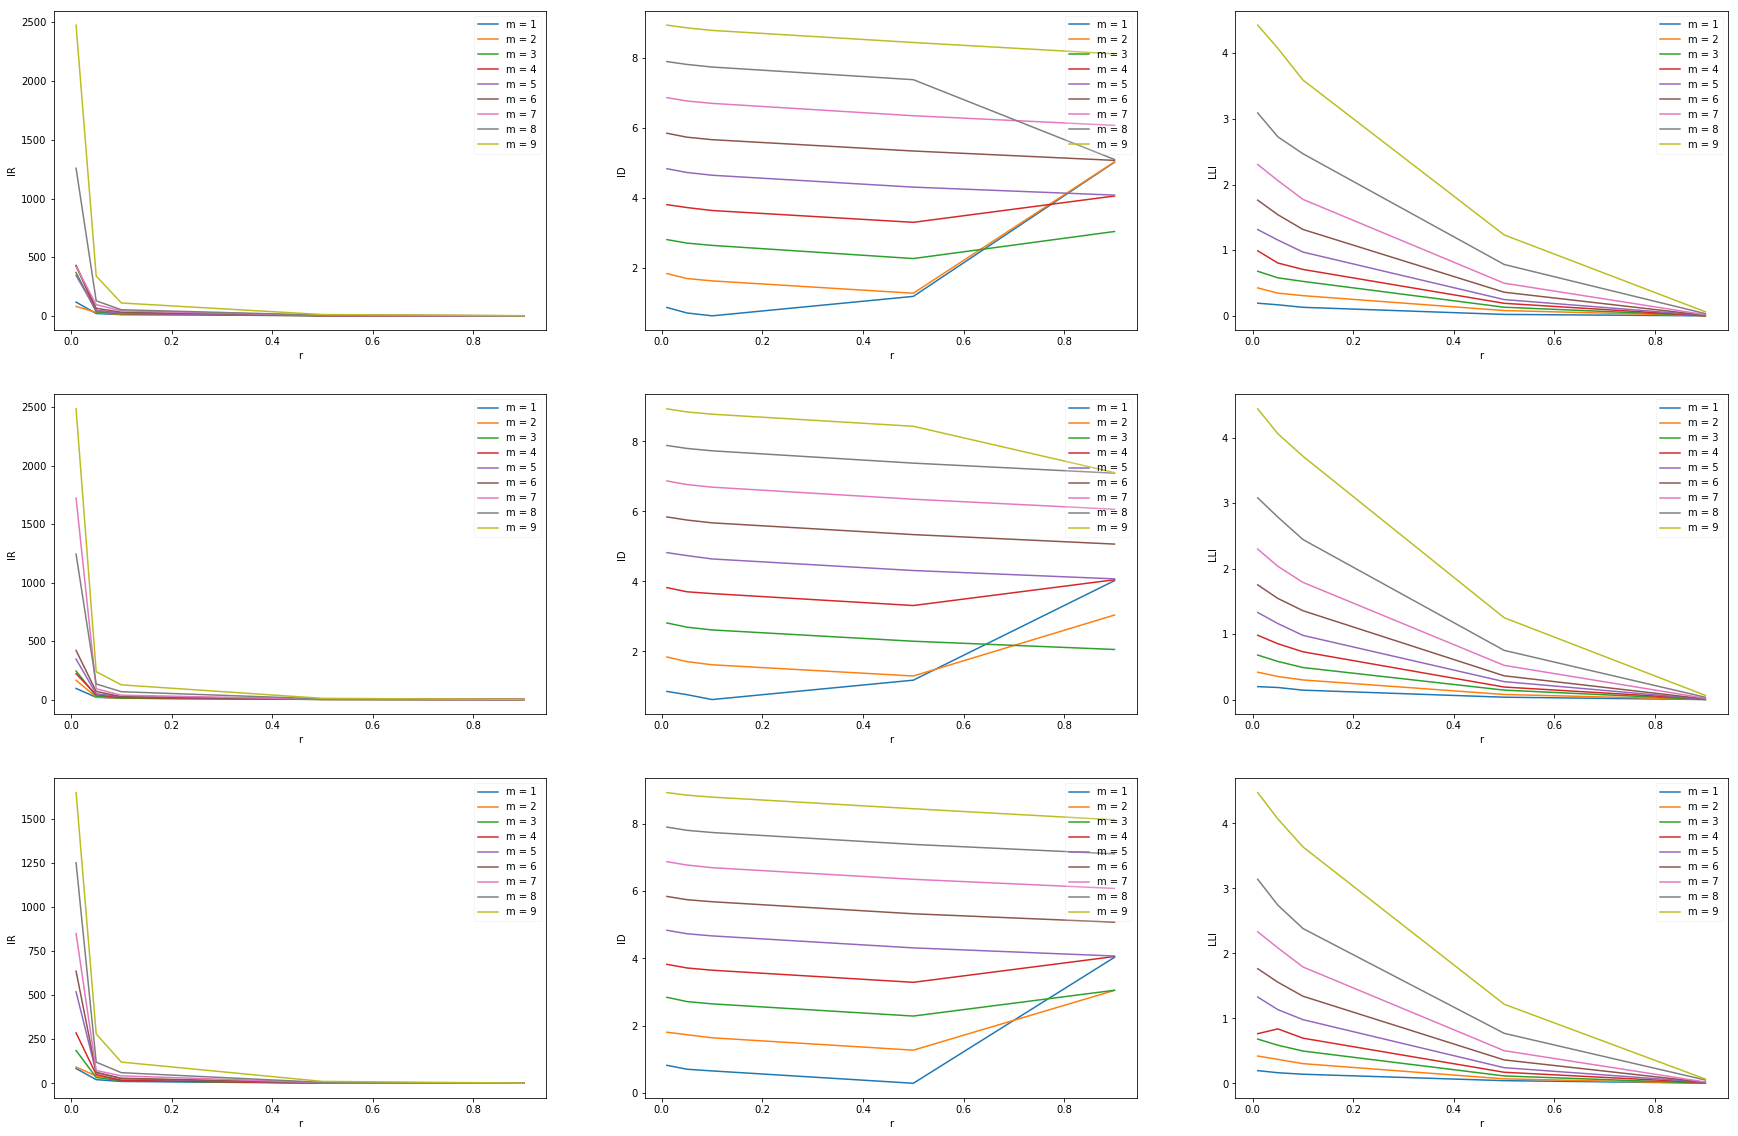

In [27]:
plt.figure(figsize=(30,20))
plt.subplot(331)
plot_graph(separated, 'ir', legend=True)
plt.subplot(332)
plot_graph(separated, 'id', legend=False)
plt.subplot(333)
plot_graph(separated, 'lli', legend=False)
plt.subplot(334)
plot_graph(overlapped, 'ir', legend=True)
plt.subplot(335)
plot_graph(overlapped, 'id', legend=False)
plt.subplot(336)
plot_graph(overlapped, 'lli', legend=False)
plt.subplot(337)
plot_graph(highly_overlapped, 'ir', legend=True)
plt.subplot(338)
plot_graph(highly_overlapped, 'id', legend=False)
plt.subplot(339)
plot_graph(highly_overlapped, 'lli', legend=False)

[0.1952942258389355, 0.16372884594765613, 0.14085968645918923, 0.03154705471965505, 0.002533254808379487]
[0.4285143473594472, 0.3620222019984994, 0.30465640163678137, 0.07039332626234193, 0.0045480804190402395]
[0.6690606963046376, 0.5789216459010625, 0.4964272366212274, 0.10816275769666213, 0.0030654012764668188]
[0.9737331123439743, 0.8581928091516652, 0.7365401029208122, 0.18300304353217406, 0.006486660700492978]
[1.3076119130079515, 1.179306985563664, 0.9810783178977797, 0.25670666086553495, 0.012205978634155856]
[1.7550566427391792, 1.5425722453718418, 1.3273768540928306, 0.37417291700114896, 0.019997520950914137]
[2.3039802865485575, 2.0733392860654734, 1.79589702582488, 0.5127154221374736, 0.015612248519990438]
[3.111180608595384, 2.7940833846863447, 2.4160653185277052, 0.7862669038523825, 0.029413148508862168]
[4.466386157850351, 4.018121292834705, 3.629524706235027, 1.2516014207308266, 0.06905689061288596]


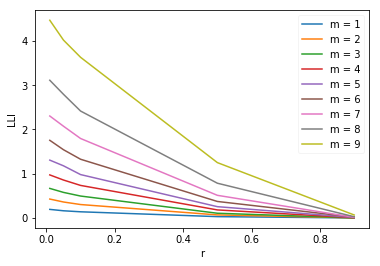

In [35]:
plot_graph(highly_overlapped, 'lli', legend=True)

[0.200989701344211, 0.16952322629850763, 0.14016888320254633, 0.03774557624366018, 0.004355325801188234]
[0.43031381279356495, 0.3606300187246889, 0.30815730866254787, 0.0671597479263755, 0.0037208447911888723]
[0.6834091524186368, 0.560727746804191, 0.5012515757954562, 0.1313537169589004, 0.002793124174853799]
[0.9773156279931088, 0.8538715810170023, 0.6903490647806441, 0.21898191799919509, 0.012811401054608082]
[1.3467163102216593, 1.1608996935556855, 0.9841820426087097, 0.2637923260614208, 0.007874599184660373]
[1.7590003897200135, 1.54738229685882, 1.343931831263774, 0.3807871437554073, 0.01781736700175798]
[2.121472707510901, 2.059654442976562, 1.7536650710506014, 0.5080167756540046, 0.025319379078617556]
[3.1275990498321415, 2.7840277892511556, 2.447014113517726, 0.7277226525271641, 0.04276586773349896]
[4.458630057341288, 4.032296506972418, 3.5968818734263683, 1.2038173353289316, 0.07189716218195481]


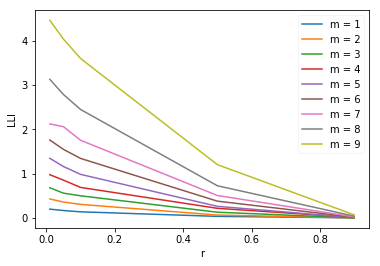

In [36]:
plot_graph(overlapped, 'lli', legend=True)

[0.20025633069938883, 0.1707105467652831, 0.14228748609413353, 0.038607716050242435, 0.0032450568599571086]
[0.4223327023292799, 0.3640955240695918, 0.30567029457305134, 0.07463199859896404, 0.003254054841415204]
[0.46839112616569833, 0.5974558982175745, 0.49582863159856055, 0.10922139802677946, 0.006496657926502447]
[0.9838904731121231, 0.8430532683802111, 0.7261720429659081, 0.18471172135749003, 0.012027407705156437]
[1.305296967513486, 1.1536381654012877, 0.9916984038263137, 0.27938697971147747, 0.012814025024808409]
[1.7617059707014808, 1.5855883219796771, 1.2966745042310557, 0.3757092835290619, 0.020907277134792623]
[2.3049612139000857, 2.0617268141909246, 1.792522157336158, 0.513371116860537, 0.027028756334329593]
[3.1177989228802434, 2.779399029024548, 2.408573129005344, 0.75117432538318, 0.035117741950355996]
[4.48154549966279, 4.08479830318994, 3.5678932172179976, 1.2327106493678477, 0.06773595646545269]


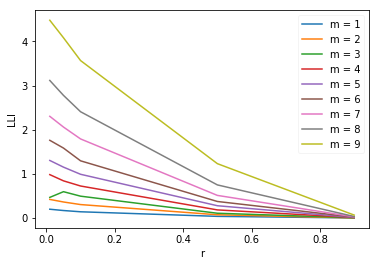

In [37]:
plot_graph(separated, 'lli', legend=True)